# 

#  <span style="color:lightblue" font="bold"> Baseline Tumor Categorization </span>

In [4]:
### Importing the necessary libraries

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

from PIL import Image

ImportError: cannot import name 'runtime_version' from 'google.protobuf' (/Users/abirbou/.pyenv/versions/3.10.6/envs/brain_tumor_detection_project/lib/python3.10/site-packages/google/protobuf/__init__.py)

#### 1. <span style="color:lightblue" font="bold"> Loading the dataset </span>

In [ ]:
# Define the path to the classification dataset (relative to the notebook location)
data_dir = Path("../raw_data/classification/Training")
test_dir = Path("../raw_data/classification/Testing")
os.listdir(data_dir)
os.listdir(test_dir)

['pituitary', '.DS_Store', 'notumor', 'glioma', 'meningioma']

##### OPTIONAL : Adding other images 

In [ ]:
# FILE_PATH = Path("../raw_data/brain_tumor_df_processed.pkl")
# df_charge = pd.read_pickle(FILE_PATH)
# df_charge.head()

# df_charge.drop(columns=['tumorMask', 'PID', 'filename'], inplace= True)
# mapping = {
#     1: 'meningioma',
#     2: 'glioma',
#     3: 'pituitary'
# }

# df_charge["tumor_type_encoded"] = df_charge.label.map(mapping)

# # 1. Rename tumor_type_encoded -> tumor_type
# df_charge = df_charge.rename(columns={"tumor_type_encoded": "tumor_type"})

# # 2. Create new tumor_type_encoded from label
# df_charge["tumor_type_encoded"] = df_charge["label"]

# # 3. (Optional) Drop the old label column
# df_charge = df_charge.drop(columns=["label"])

# # 4. (Optional) Reorder columns exactly as you want
# df_charge = df_charge[["image", "tumor_type", "tumor_type_encoded"]]

# def resize_to_128(x):
#     x = np.array(x)
#     img = Image.fromarray(x)          # assume x is 2D grayscale
#     img = img.resize((128, 128))      # resize
#     arr = np.array(img)
#     return arr.reshape(128, 128, 1)   

# df_charge["image"] = df_charge["image"].apply(resize_to_128)
# df_charge.image = df_charge.image / 255.


#### 1.1 Removing duplicates

In [ ]:
from pathlib import Path
import hashlib
import os

# --- Paramès ---
DATASET_ROOT = Path("../raw_data/classification")  # dossier racine contenant Training/ et Testing/
CLASSES = ["glioma", "pituitary", "meningioma", "notumor"]
SPLITS_ORDER = ["Training", "Testing"]  # Priorité : on garde ce qu'on voit en premier
EXTENSIONS = (".jpg", ".jpeg", ".png", ".bmp")  # adapte si besoin
DRY_RUN = False  # Mettre False pour réellement supprimer les fichiers

# ----------------------------

def file_hash(path, algo="md5", block_size=65536):
    """Hash du fichier basé sur son contenu (rapide et robuste pour duplicats exacts)."""
    h = hashlib.new(algo)
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(block_size), b""):
            h.update(chunk)
    return h.hexdigest()


def list_all_images():
    """Retourne la liste de tous les chemins d’images (Training + Testing, toutes classes)."""
    all_paths = []
    for split in SPLITS_ORDER:  # Training d'abord, puis Testing
        for cls in CLASSES:
            folder = DATASET_ROOT / split / cls
            if not folder.exists():
                print(f"⚠️ Dossier absent : {folder}")
                continue
            for ext in EXTENSIONS:
                all_paths.extend(folder.rglob(f"*{ext}"))
    return all_paths


def find_duplicates(paths):
    """
    Retourne:
        - hash_to_files: dict hash -> [liste des fichiers]
        - duplicates: liste de listes [fichier_à_garder, fichier_dup1, fichier_dup2, ...]
    """
    hash_to_files = {}
    for i, p in enumerate(paths, 1):
        if i % 500 == 0:
            print(f"Scanné {i} fichiers...")
        h = file_hash(p)
        hash_to_files.setdefault(h, []).append(p)

    duplicates_groups = []
    for h, files in hash_to_files.items():
        if len(files) > 1:
            # garder le premier (selon ordre SPLITS_ORDER)
            keep = files[0]
            dups = files[1:]
            duplicates_groups.append([keep] + dups)

    return hash_to_files, duplicates_groups


def main():
    print("🔍 Listing des images...")
    all_paths = list_all_images()
    print(f"Total d'images trouvées : {len(all_paths)}")

    print("🧮 Calcul des hash et recherche des doublons...")
    _, duplicates_groups = find_duplicates(all_paths)

    if not duplicates_groups:
        print("✅ Aucun doublon exact trouvé.")
        return

    total_dups = sum(len(g) - 1 for g in duplicates_groups)
    print(f"⚠️ Nombre de groupes de doublons : {len(duplicates_groups)}")
    print(f"⚠️ Nombre total de fichiers en trop : {total_dups}\n")

    # Afficher un aperçu
    print("Exemple de groupe de doublons :")
    for g in duplicates_groups[:3]:  # maximum 3 groupes affichés
        print("  À garder :", g[0])
        for d in g[1:]:
            print("    Doublon :", d)
        print()

    if DRY_RUN:
        print("Mode DRY_RUN = True : aucun fichier ne sera supprimé.")
        print("Si tout te semble OK, passe DRY_RUN à False et relance.")
        return

    # Suppression effective
    print("🗑 Suppression des doublons...")
    deleted = 0
    for group in duplicates_groups:
        to_delete = group[1:]  # on garde group[0]
        for f in to_delete:
            try:
                os.remove(f)
                deleted += 1
            except Exception as e:
                print(f"Erreur en supprimant {f}: {e}")

    print(f"✅ Suppression terminée. Fichiers supprimés : {deleted}")


# if __name__ == "__main__":
main()

🔍 Listing des images...
Total d'images trouvées : 13899
🧮 Calcul des hash et recherche des doublons...
Scanné 500 fichiers...
Scanné 1000 fichiers...
Scanné 1500 fichiers...
Scanné 2000 fichiers...
Scanné 2500 fichiers...
Scanné 3000 fichiers...
Scanné 3500 fichiers...
Scanné 4000 fichiers...
Scanné 4500 fichiers...
Scanné 5000 fichiers...
Scanné 5500 fichiers...
Scanné 6000 fichiers...
Scanné 6500 fichiers...
Scanné 7000 fichiers...
Scanné 7500 fichiers...
Scanné 8000 fichiers...
Scanné 8500 fichiers...
Scanné 9000 fichiers...
Scanné 9500 fichiers...
Scanné 10000 fichiers...
Scanné 10500 fichiers...
Scanné 11000 fichiers...
Scanné 11500 fichiers...
Scanné 12000 fichiers...
Scanné 12500 fichiers...
Scanné 13000 fichiers...
Scanné 13500 fichiers...
✅ Aucun doublon exact trouvé.


##### 1.2 Creating a dataframe of images paths and labels

In [ ]:
# Collect image paths and their corresponding tumor types
image_paths = []
labels = []

for tumor_type in os.listdir(data_dir):
    tumor_type_path = data_dir/tumor_type
    if os.path.isdir(tumor_type_path):
        for img_name in os.listdir(tumor_type_path):
            img_path = tumor_type_path / img_name
            # Optional: filter only image files
            if img_path.suffix.lower() in [".png", ".jpg", ".jpeg"]:
                image_paths.append(str(img_path))
                labels.append(tumor_type)

# Create a DataFrame for the dataset
df = pd.DataFrame({
    "image_path": image_paths,
    "tumor_type": labels
})

# Show the first few rows for verification
print(df.shape)
df.head(10)


(11410, 2)


,image_path,tumor_type
0,../raw_data/classification/Training/pituitary/...,pituitary
1,../raw_data/classification/Training/pituitary/...,pituitary
2,../raw_data/classification/Training/pituitary/...,pituitary
3,../raw_data/classification/Training/pituitary/...,pituitary
4,../raw_data/classification/Training/pituitary/...,pituitary
5,../raw_data/classification/Training/pituitary/...,pituitary
6,../raw_data/classification/Training/pituitary/...,pituitary
7,../raw_data/classification/Training/pituitary/...,pituitary
8,../raw_data/classification/Training/pituitary/...,pituitary
9,../raw_data/classification/Training/pituitary/...,pituitary


#### 2. One-hot Encoding Tumor Types

In [ ]:
# One-hot encoding the tumor types
mapping = {
    'notumor': 0,
    'meningioma': 1,
    'glioma': 2,
    'pituitary': 3
}

df["tumor_type_encoded"] = df["tumor_type"].map(mapping)
df.head()

,image_path,tumor_type,tumor_type_encoded
0,../raw_data/classification/Training/pituitary/...,pituitary,3
1,../raw_data/classification/Training/pituitary/...,pituitary,3
2,../raw_data/classification/Training/pituitary/...,pituitary,3
3,../raw_data/classification/Training/pituitary/...,pituitary,3
4,../raw_data/classification/Training/pituitary/...,pituitary,3


#### 3. First Model Training

#####        3.1 Define image loading function and the training / validation sets

In [ ]:
from tensorflow.lite.python import convert
def load_image(path):
    img = Image.open(path).convert("L")
    arr = np.array(img, dtype=np.float32)
    return arr

In [ ]:
def load_process_image(path):
    img = Image.open(path).convert("L")
    img = img.resize(size=(256, 256))
    arr = np.array(img, dtype=np.float32)
    arr = arr / 255.
    return arr

In [ ]:
X_paths = df.image_path
X = X_paths.apply(lambda x : load_process_image(x))
X = np.stack(X, axis=0) 
X = X.reshape(-1, 256, 256, 1)
print("X shape :", X.shape)

X shape : (11410, 256, 256, 1)


In [ ]:
y = df.tumor_type_encoded
print("y shape :", y.shape)

y shape : (11410,)


In [ ]:
df['image'] = list(X)
col = df.pop("image")        # remove "C" and get its Series
df.insert(0, "image", col)   # insert at position 0 (first)
df.drop(columns='image_path', inplace=True)

In [ ]:
df.shape

(11410, 3)

<Axes: xlabel='tumor_type', ylabel='count'>

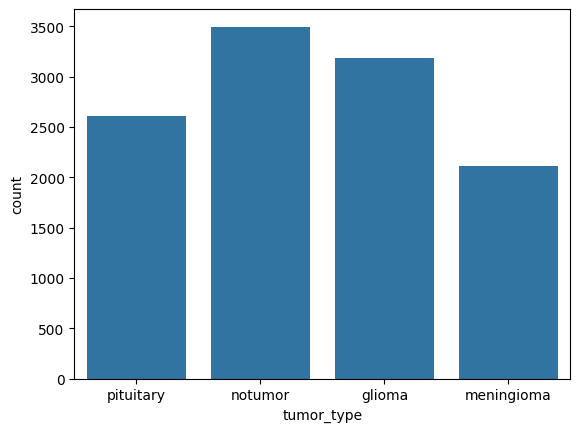

In [ ]:
sns.countplot(x="tumor_type", data=df)

#### 3. Definie model

In [ ]:
def init_baseline(input_shape, num_classes=4):
    model = Sequential()
    model.add(Input(shape=input_shape))

    # Block 1
    model.add(layers.Conv2D(32, (3, 3),
                            padding='same',
                            activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    # Block 2
    model.add(layers.Conv2D(64, (3, 3),
                            padding='same',
                            activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    # Global pooling instead of Flatten
    model.add(layers.GlobalAveragePooling2D())

    # Small dense head
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

In [ ]:
from tensorflow.keras.metrics import Recall

def compile_model(model):
    '''return a compiled model suited for the CIFAR-10 task'''
    model.compile(optimizer= 'adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=["accuracy"])
    return model


In [ ]:
model = init_baseline(input_shape=X.shape[1:], num_classes=4)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 global_average_pooling2d (G  (None, 64)               0         
 lobalAveragePooling2D)                                          
                                                        

In [ ]:
model = compile_model(model)
es = EarlyStopping(patience=3, restore_best_weights=True)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)

# Set memory growth on all available GPUs

import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Devices:", tf.config.list_physical_devices())

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs found:", gpus)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth set OK")
    except Exception as e:
        print("Error setting memory growth:", e)
else:
    print("No GPU found. Training will use CPU.")



history = model.fit(X_train, y_train,
                        epochs=5,
                        batch_size=64,
                        validation_data= (X_val, y_val),
                        verbose=1,
                        callbacks=[es])

NameError: name 'compile_model' is not defined

(2495, 2)


<Axes: xlabel='test_tumor_type', ylabel='count'>

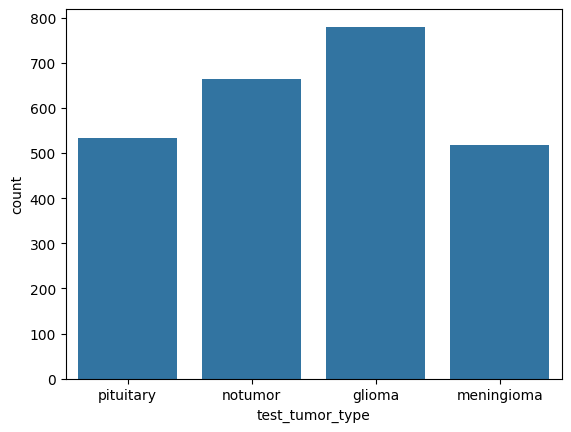

In [ ]:
# Collect image paths and their corresponding tumor types
from scipy import test


test_paths = []
test_labels = []

for tumor_type in os.listdir(test_dir):
    tumor_type_path = test_dir/tumor_type
    if os.path.isdir(tumor_type_path):
        for test_img_name in os.listdir(tumor_type_path):
            test_img_path = tumor_type_path / test_img_name
            # Optional: filter only image files
            if test_img_path.suffix.lower() in [".png", ".jpg", ".jpeg"]:
                test_paths.append(str(test_img_path))
                test_labels.append(tumor_type)

# Create a DataFrame for the dataset
test_df = pd.DataFrame({
    "test_image_path": test_paths,
    "test_tumor_type": test_labels
})

# Show the first few rows for verification
print(test_df.shape)
test_df.head(10)

sns.countplot(x="test_tumor_type", data=test_df)

In [ ]:
test_df

,test_image_path,test_tumor_type
0,../raw_data/classification/Testing/pituitary/B...,pituitary
1,../raw_data/classification/Testing/pituitary/T...,pituitary
2,../raw_data/classification/Testing/pituitary/T...,pituitary
3,../raw_data/classification/Testing/pituitary/B...,pituitary
4,../raw_data/classification/Testing/pituitary/M...,pituitary
...,...,...
2490,../raw_data/classification/Testing/meningioma/...,meningioma
2491,../raw_data/classification/Testing/meningioma/...,meningioma
2492,../raw_data/classification/Testing/meningioma/...,meningioma
2493,../raw_data/classification/Testing/meningioma/...,meningioma


In [ ]:
# One-hot encoding the tumor types
mapping = {
    'notumor': 0,
    'meningioma': 1,
    'glioma': 2,
    'pituitary': 3
}

test_df["test_tumor_type_encoded"] = test_df["test_tumor_type"].map(mapping)
test_df.head()

,test_image_path,test_tumor_type,test_tumor_type_encoded
0,../raw_data/classification/Testing/pituitary/B...,pituitary,3
1,../raw_data/classification/Testing/pituitary/T...,pituitary,3
2,../raw_data/classification/Testing/pituitary/T...,pituitary,3
3,../raw_data/classification/Testing/pituitary/B...,pituitary,3
4,../raw_data/classification/Testing/pituitary/M...,pituitary,3


In [ ]:
# Define the test set
X_test_paths = test_df.test_image_path
X_test = X_test_paths.apply(lambda X_test : load_process_image(X_test))
X_test = np.stack(X_test, axis=0) 
X_test = X_test.reshape(-1, 128, 128, 1)

y_test = test_df.test_tumor_type_encoded

print(y_test.shape, X_test.shape)

(2495,) (2495, 128, 128, 1)


In [ ]:
results = model.evaluate(X_test, y_test, batch_size=32)
results

78/78 [==============================] - 1s 14ms/step - loss: 1.0926 - accuracy: 0.5792


[1.0926414728164673, 0.5791583061218262]

In [ ]:
y_pred = model.predict(X_test)

78/78 [==============================] - 1s 15ms/step


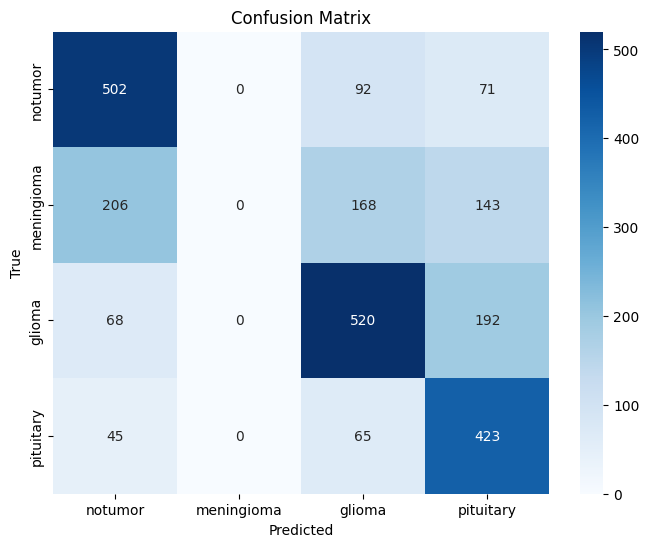

In [ ]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_true=y_test, y_pred=np.argmax(y_pred, axis=1))
plt.figure(figsize=(8, 6))
tumor_type_labels = ['notumor', 'meningioma', 'glioma', 'pituitary']
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=tumor_type_labels, yticklabels=tumor_type_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

#### 4. Fine-tune categorization model

In [ ]:
IMG_SIZE + (3,)

(128, 128, 3)

In [ ]:
IMG_SIZE = (128, 128)
NUM_CLASSES = 4

def create_transfer_model(input_shape=IMG_SIZE + (3,), num_classes=NUM_CLASSES):
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )
    base_model.trainable = False  # freeze at first

    inputs = Input(shape=input_shape)
    x = tf.keras.applications.efficientnet.preprocess_input(inputs)
    x = base_model(x, training=False)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model


transfer_model = create_transfer_model()
transfer_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


history = transfer_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True
        )
    ]
)


Epoch 1/10
250/250 [==============================] - 43s 157ms/step - loss: 1.3949 - accuracy: 0.2870 - val_loss: 1.3692 - val_accuracy: 0.3129
Epoch 2/10
250/250 [==============================] - 40s 160ms/step - loss: 1.3830 - accuracy: 0.2972 - val_loss: 1.3730 - val_accuracy: 0.2726
Epoch 3/10
250/250 [==============================] - 39s 154ms/step - loss: 1.3761 - accuracy: 0.3211 - val_loss: 1.3867 - val_accuracy: 0.2378
Epoch 4/10
250/250 [==============================] - 40s 161ms/step - loss: 1.3753 - accuracy: 0.3156 - val_loss: 1.3631 - val_accuracy: 0.3298
Epoch 5/10
206/250 [=======================>......] - ETA: 5s - loss: 1.3761 - accuracy: 0.3166

KeyboardInterrupt: 

In [ ]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 4,054,695
Trainable params: 5,124
Non-trainable params: 4,049,571
_________________________________________________________________
